---
title: "Lab 6"
author: "Shawheen Ghezavat"
format:
  html:
    embed-resources: true
jupyter: python3
---
[View this project on GitHub]()

# Imports

In [159]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from plotnine import *


In [160]:
df = pd.read_csv("Hitters.csv")
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [161]:
# Drop rows where Salary is missing
print(f"Original dataset shape: {df.shape}")
print(f"Number of missing Salary values: {df['Salary'].isna().sum()}")
df = df.dropna(subset=['Salary'])
print(f"After removing missing Salary values: {df.shape}")

Original dataset shape: (322, 20)
Number of missing Salary values: 59
After removing missing Salary values: (263, 20)


# Part I: Different Model Specs

## A. Regression without regularization

In [162]:
# Prepare X and y
X = df.drop("Salary", axis=1)
y = df["Salary"]

# Create column transformer for preprocessing
ct = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

# Create OLS pipeline
ols_pipeline = Pipeline([
    ("preprocessing", ct),
    ("linear_regression", LinearRegression())
])

In [163]:
# Fit the OLS pipeline to the full dataset
ols_pipeline.fit(X, y)

# Get coefficients and feature names
ols_coefs = ols_pipeline.named_steps['linear_regression'].coef_
feature_names = ols_pipeline.named_steps['preprocessing'].get_feature_names_out()

# Create a dataframe of coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': ols_coefs
})

# Sort by absolute value to find most important coefficients
coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
coef_df_sorted = coef_df.sort_values('abs_coef', ascending=False)

print("Top 10 Most Important Coefficients (OLS):")
print(coef_df_sorted[['feature', 'coefficient']].head(10))

Top 10 Most Important Coefficients (OLS):
                 feature  coefficient
16    standardize__CRuns   480.747135
13   standardize__CAtBat  -391.038655
7      standardize__Hits   337.830479
6     standardize__AtBat  -291.094556
17     standardize__CRBI   260.689886
18   standardize__CWalks  -213.892259
11    standardize__Walks   135.073897
14    standardize__CHits    86.687617
19  standardize__PutOuts    78.761296
9      standardize__Runs   -60.572479


**Interpretation of OLS Coefficients:**

Looking at the top coefficients, the model dictates that runs, career at bats, 1986 hits, 1986 at bats, and career rbi are important coefficients(top 5) given their magnitudes. The standardized coefficients show the relative importance of each variable in predicting a player's salary, controlling for all other variables in the model.

In [164]:
# Use cross-validation to estimate MSE (use negative MSE as scoring metric)
ols_mse_scores = -cross_val_score(ols_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
ols_mean_mse = ols_mse_scores.mean()

print(f"OLS MSE: {ols_mean_mse:.2f}")
print(f"OLS RMSE: {np.sqrt(ols_mean_mse):.2f}")

OLS MSE: 121136.31
OLS RMSE: 348.05


If I used this pipeline to predict 1989 salaries, the MSE would be 121136.31.

## B. Ridge Regression

In [165]:
# Create Ridge pipeline
ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ridge", Ridge())
])

# Define parameter grid for lambda (alpha in sklearn)
param_grid = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Use GridSearchCV to tune lambda
ridge_grid = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X, y)

,estimator,"Pipeline(step...e', Ridge())])"
,param_grid,"{'ridge__alpha': [0.001, 0.01, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('dummify', ...), ('standardize', ...)]"


In [166]:
# Fit Ridge with best lambda to full dataset and interpret coefficients
ridge_best = ridge_grid.best_estimator_
ridge_coefs = ridge_best.named_steps['ridge'].coef_
ridge_feature_names = ridge_best.named_steps['preprocessing'].get_feature_names_out()

# Create coefficient dataframe
ridge_coef_df = pd.DataFrame({
    'feature': ridge_feature_names,
    'coefficient': ridge_coefs
})
ridge_coef_df['abs_coef'] = np.abs(ridge_coef_df['coefficient'])
ridge_coef_df_sorted = ridge_coef_df.sort_values('abs_coef', ascending=False)

print("Top 10 Most Important Coefficients (Ridge):")
print(ridge_coef_df_sorted[['feature', 'coefficient']].head(10))

Top 10 Most Important Coefficients (Ridge):
                 feature  coefficient
16    standardize__CRuns   320.412169
7      standardize__Hits   296.645050
6     standardize__AtBat  -270.686441
13   standardize__CAtBat  -225.406548
18   standardize__CWalks  -184.423611
17     standardize__CRBI   160.386784
14    standardize__CHits   126.659607
11    standardize__Walks   124.407173
19  standardize__PutOuts    78.623656
3    dummify__Division_W   -60.015595


**Interpretation of Ridge Coefficients:**

The Ridge regression model shrinks coefficients toward zero but doesn't eliminate them entirely. The most important features identified by Ridge regression are career runs, 1986 hits, 1986 at bats, career at bats, and career walks. These have the strongest relationship with salary after accounting for multicollinearity.

In [167]:
# Report expected MSE for Ridge
ridge_mse = -ridge_grid.best_score_
ridge_rmse = np.sqrt(ridge_mse)

print(f"Best λ (alpha): {ridge_grid.best_params_['ridge__alpha']}")
print(f"MSE for Ridge: {ridge_mse:.2f}")
print(f"RMSE for Ridge: {ridge_rmse:.2f}")

Best λ (alpha): 1
MSE for Ridge: 119144.43
RMSE for Ridge: 345.17


If I used this pipeline to predict 1989 salaries, the MSE would be 119144.43.

## C. Lasso Regression

In [168]:
# Create Lasso pipeline
lasso_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lasso", Lasso(max_iter=10000))  # Increase max_iter to avoid convergence warnings
])

# Define parameter grid for lambda (alpha in sklearn)
param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Use GridSearchCV to tune lambda
lasso_grid = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X, y)

,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'lasso__alpha': [0.001, 0.01, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('dummify', ...), ('standardize', ...)]"


In [169]:
# Fit Lasso with best lambda to full dataset and interpret coefficients
lasso_best = lasso_grid.best_estimator_
lasso_coefs = lasso_best.named_steps['lasso'].coef_
lasso_feature_names = lasso_best.named_steps['preprocessing'].get_feature_names_out()

# Create coefficient dataframe
lasso_coef_df = pd.DataFrame({
    'feature': lasso_feature_names,
    'coefficient': lasso_coefs
})
lasso_coef_df['abs_coef'] = np.abs(lasso_coef_df['coefficient'])
lasso_coef_df_sorted = lasso_coef_df.sort_values('abs_coef', ascending=False)


print(f"\nTop 10 Most Important Coefficients (Lasso):")
print(lasso_coef_df_sorted[lasso_coef_df_sorted['coefficient'] != 0][['feature', 'coefficient']].head(10))


Top 10 Most Important Coefficients (Lasso):
                 feature  coefficient
16    standardize__CRuns   375.565519
7      standardize__Hits   304.359509
6     standardize__AtBat  -282.370957
17     standardize__CRBI   192.610892
18   standardize__CWalks  -189.644642
13   standardize__CAtBat  -162.639794
11    standardize__Walks   120.695275
2    dummify__Division_E   114.412951
19  standardize__PutOuts    78.760366
20  standardize__Assists    41.996680


**Interpretation of Lasso Coefficients:**

Lasso regression performs both regularization and variable selection by setting some coefficients exactly to zero. This method identified the most important coefficients affecting Salary to be career runs, 1986 hits, 1986 at bats, career rbis, and career walks. 

In [170]:
# Report expected MSE for Lasso
lasso_mse = -lasso_grid.best_score_
lasso_rmse = np.sqrt(lasso_mse)

print(f"Best λ (alpha): {lasso_grid.best_params_['lasso__alpha']}")
print(f"MSE for Lasso: {lasso_mse:.2f}")
print(f"RMSE for Lasso: {lasso_rmse:.2f}")

Best λ (alpha): 1
MSE for Lasso: 119758.11
RMSE for Lasso: 346.06


If I used this pipeline to predict 1989 salaries, the MSE would be 119758.11.

## D. Elastic Net

In [171]:
# Create Elastic Net pipeline
elastic_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elastic", ElasticNet(max_iter=10000))
])

# Define parameter grid for lambda (alpha) and mixing parameter (l1_ratio)
# l1_ratio: 0 = Ridge, 1 = Lasso, in between = mix of both
param_grid = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elastic__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
}

# Use GridSearchCV to tune both hyperparameters
elastic_grid = GridSearchCV(elastic_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
elastic_grid.fit(X, y)

,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'elastic__alpha': [0.001, 0.01, ...], 'elastic__l1_ratio': [0.0, 0.2, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('dummify', ...), ('standardize', ...)]"


In [172]:
# Fit Elastic Net with best hyperparameters and interpret coefficients
elastic_best = elastic_grid.best_estimator_
elastic_coefs = elastic_best.named_steps['elastic'].coef_
elastic_feature_names = elastic_best.named_steps['preprocessing'].get_feature_names_out()

# Create coefficient dataframe
elastic_coef_df = pd.DataFrame({
    'feature': elastic_feature_names,
    'coefficient': elastic_coefs
})
elastic_coef_df['abs_coef'] = np.abs(elastic_coef_df['coefficient'])
elastic_coef_df_sorted = elastic_coef_df.sort_values('abs_coef', ascending=False)

print(f"\nTop 10 Most Important Coefficients (Elastic Net):")
print(elastic_coef_df_sorted[elastic_coef_df_sorted['coefficient'] != 0][['feature', 'coefficient']].head(10))


Top 10 Most Important Coefficients (Elastic Net):
                 feature  coefficient
7      standardize__Hits   249.932749
6     standardize__AtBat  -233.288540
16    standardize__CRuns   226.828888
18   standardize__CWalks  -156.494374
14    standardize__CHits   123.652473
17     standardize__CRBI   122.933277
13   standardize__CAtBat  -122.140519
11    standardize__Walks   111.867858
19  standardize__PutOuts    77.975919
2    dummify__Division_E    60.813167


**Interpretation of Elastic Net Coefficients:**

Elastic Net combines both Lasso and Ridge, allowing it to both perform variable selection and handle multicollinearity. The alpha controls the overall regularization strength, while l1_ratio determines the balance between Ridge and Lasso penalties. This hybrid approach allows the model to both perform variable selection and handle multicollinearity. The selected features: 1986 hits, 1986 at bats, career runs, career walks, and career hits, represent the most important predictors for Salary, identified by this hybrid approach.

In [173]:
# Report expected MSE for Elastic Net
elastic_mse = -elastic_grid.best_score_
elastic_rmse = np.sqrt(elastic_mse)

print(f"Best λ (alpha): {elastic_grid.best_params_['elastic__alpha']}")
print(f"Best α (l1_ratio): {elastic_grid.best_params_['elastic__l1_ratio']}")
print(f"Best MSE for Elastic Net: {elastic_mse:.2f}")
print(f"Best RMSE for Elastic Net: {elastic_rmse:.2f}")

Best λ (alpha): 0.01
Best α (l1_ratio): 0.0
Best MSE for Elastic Net: 118957.97
Best RMSE for Elastic Net: 344.90


If I used this pipeline to predict 1989 salaries, the MSE would be 118957.97.

In [174]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'Elastic Net'],
    'MSE': [ols_mean_mse, ridge_mse, lasso_mse, elastic_mse],
    'RMSE': [np.sqrt(ols_mean_mse), ridge_rmse, lasso_rmse, elastic_rmse],
})

comparison_df = comparison_df.sort_values('MSE')
print("Model Comparison (sorted by MSE):")
print(comparison_df.to_string(index=False))

Model Comparison (sorted by MSE):
      Model           MSE       RMSE
Elastic Net 118957.968889 344.902840
      Ridge 119144.432677 345.173047
      Lasso 119758.108873 346.060846
        OLS 121136.310318 348.046420


# Part 2: Variable Selection

I performed variable selection by averaging the absolute coefficient values across Ridge, Lasso, and Elastic Net
models from Part I to create a robust importance ranking. I used the top-ranked numeric variable for Feature Set
1, the top 5 numeric variables for Feature Sets 2 and 3, and added the highest-ranked categorical variable
(Division) to Feature Set 3 for interaction modeling.

In [175]:
# Identify most important variables by averaging absolute coefficients across Ridge, Lasso, and Elastic Net

# Create a dataframe with all coefficients
importance_df = pd.DataFrame({
    'feature': ridge_feature_names,  # All three models have same features
    'ridge_abs': np.abs(ridge_coefs),
    'lasso_abs': np.abs(lasso_coefs),
    'elastic_abs': np.abs(elastic_coefs)
})

# Calculate average absolute coefficient across the 3 models
importance_df['avg_abs_coef'] = importance_df[['ridge_abs', 'lasso_abs', 'elastic_abs']].mean(axis=1)

# Sort by average importance
importance_df = importance_df.sort_values('avg_abs_coef', ascending=False)

# Rename for some other code portion I wrote prior
combined_importance = importance_df[['feature', 'avg_abs_coef']].copy()
combined_importance.columns = ['feature', 'abs_coef']

# Filter for numeric and categorical variables
numeric_vars = combined_importance[combined_importance['feature'].str.contains('standardize__')]
categorical_vars = combined_importance[combined_importance['feature'].str.contains('dummify__')]

print("Top 10 Numeric Variables (averaged across Ridge, Lasso, Elastic Net):")
print(importance_df[importance_df['feature'].str.contains('standardize__')][['feature', 'ridge_abs', 'lasso_abs', 'elastic_abs', 'avg_abs_coef']].head(10).to_string(index=False))
print("\nTop 5 Categorical Variables (averaged across Ridge, Lasso, Elastic Net):")
print(importance_df[importance_df['feature'].str.contains('dummify__')][['feature', 'ridge_abs', 'lasso_abs', 'elastic_abs', 'avg_abs_coef']].head(5).to_string(index=False))

Top 10 Numeric Variables (averaged across Ridge, Lasso, Elastic Net):
             feature  ridge_abs  lasso_abs  elastic_abs  avg_abs_coef
  standardize__CRuns 320.412169 375.565519   226.828888    307.602192
   standardize__Hits 296.645050 304.359509   249.932749    283.645769
  standardize__AtBat 270.686441 282.370957   233.288540    262.115313
 standardize__CWalks 184.423611 189.644642   156.494374    176.854209
 standardize__CAtBat 225.406548 162.639794   122.140519    170.062287
   standardize__CRBI 160.386784 192.610892   122.933277    158.643651
  standardize__Walks 124.407173 120.695275   111.867858    118.990102
  standardize__CHits 126.659607   0.000000   123.652473     83.437360
standardize__PutOuts  78.623656  78.760366    77.975919     78.453314
standardize__Assists  47.462597  41.996680    41.454944     43.638073

Top 5 Categorical Variables (averaged across Ridge, Lasso, Elastic Net):
             feature  ridge_abs    lasso_abs  elastic_abs  avg_abs_coef
 dummify__Divi

In [176]:
# Top 5 numeric variables
top_5_numeric_features = numeric_vars.head(5)['feature'].str.replace('standardize__', '').tolist()

# Top 1 numeric variable (for Feature Set 1)
top_1_numeric_feature = [top_5_numeric_features[0]]

# Top categorical variable (for Feature Set 3)
top_categorical = categorical_vars.iloc[0]['feature']
top_categorical_name = top_categorical.split('__')[1].rsplit('_', 1)[0]

print(f"Most important numeric variable (Feature Set 1): {top_1_numeric_feature[0]}")
print(f"\nTop 5 numeric variables (Feature Sets 2 & 3): {top_5_numeric_features}")
print(f"\nMost important categorical (Feature Set 3): {top_categorical_name}")

Most important numeric variable (Feature Set 1): CRuns

Top 5 numeric variables (Feature Sets 2 & 3): ['CRuns', 'Hits', 'AtBat', 'CWalks', 'CAtBat']

Most important categorical (Feature Set 3): Division


## Testing Different Feature Sets

 Takes a subset of features and evaluates how well a specified model type predicts salary. It preprocesses the data (one-hot encoding categoricals, standardizing numerics), then either: (1) runs cross-validation to get MSE for OLS, or (2) uses GridSearchCV to tune hyperparameters and find the best MSE for Ridge/Lasso/Elastic Net. Returns a dictionary with the feature set name, model type, MSE, RMSE, and best hyperparameters (if applicable). Tried to use max_iter to mitigate convergence warnings, but it didn't seem to help even at 10000

In [177]:
# Eval func

def evaluate_feature_set(X_subset, y, fs_name, model_type='ols', param_grid=None):    
    
    # Create preprocessing pipeline: one-hot encode categoricals, standardize numerics
    ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),
          make_column_selector(dtype_include=object)),
         ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))],
        remainder="drop").set_output(transform="pandas")
    
    # For OLS: no hyperparameters to tune, just get CV score
    if model_type == 'ols':
        pipe = Pipeline([("preprocessing", ct), ("model", LinearRegression())])
        mse = -cross_val_score(pipe, X_subset, y, cv=5, scoring='neg_mean_squared_error').mean()
        return {'feature_set': fs_name, 'model_type': model_type, 'mse': mse, 'rmse': np.sqrt(mse), 'best_params': {}}
    
    # For Ridge/Lasso/Elastic Net: use GridSearchCV to tune hyperparameters, max_iter to mitigate convergence warnings
    model = Ridge() if model_type == 'ridge' else Lasso(max_iter=10000) if model_type == 'lasso' else ElasticNet(max_iter=10000)
    pipe = Pipeline([("preprocessing", ct), ("model", model)])
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_subset, y)
    
    # Return best MSE, RMSE, and tuned hyperparameters
    return {'feature_set': fs_name, 'model_type': model_type, 'mse': -grid.best_score_, 
            'rmse': np.sqrt(-grid.best_score_), 'best_params': grid.best_params_}

# Test: evaluate OLS on one variable
print("Test:", evaluate_feature_set(df[['CRuns']], y, "Test", 'ols'))

Test: {'feature_set': 'Test', 'model_type': 'ols', 'mse': np.float64(143812.9359162973), 'rmse': np.float64(379.2267605487478), 'best_params': {}}


  This function evaluates a feature set with interaction terms between variables. It's identical to evaluate_feature_set except it adds a PolynomialFeatures step to the pipeline that creates all pairwise interactions (e.g., CRuns × Division). This allows the model to capture non-linear relationships where the effect of one variable depends on the value of another variable.

In [178]:
# Evaluation function with interaction terms
def eval_with_interactions(X_sub, y, fs_name, mtype='ols', pgrid=None):
    
    # Create preprocessing pipeline: one-hot encode categoricals, standardize numerics
    ct = ColumnTransformer([
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),
         make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), 
         make_column_selector(dtype_include=np.number))
    ], remainder="drop").set_output(transform="pandas")
    
    # For OLS: no hyperparameters to tune, just get CV score
    if mtype == 'ols':
        pipe = Pipeline([
            ("preprocessing", ct), 
            ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Create interaction terms
            ("model", LinearRegression())
        ])
        mse = -cross_val_score(pipe, X_sub, y, cv=5, scoring='neg_mean_squared_error').mean()
        return {'feature_set': fs_name, 'model_type': mtype, 'mse': mse, 'rmse': np.sqrt(mse), 'best_params': {}}
    
    # For Ridge/Lasso/Elastic Net: use GridSearchCV to tune hyperparameters
    model = Ridge() if mtype == 'ridge' else Lasso(max_iter=10000) if mtype == 'lasso' else ElasticNet(max_iter=10000)
    pipe = Pipeline([
        ("preprocessing", ct), 
        ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Create interaction terms
        ("model", model)
    ])
    grid = GridSearchCV(pipe, pgrid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_sub, y)
    
    # Return best MSE, RMSE, and tuned hyperparameters
    return {'feature_set': fs_name, 'model_type': mtype, 'mse': -grid.best_score_, 
            'rmse': np.sqrt(-grid.best_score_), 'best_params': grid.best_params_}

# Test: evaluate OLS with interactions on two variables
print("Test:", eval_with_interactions(df[['CRuns', 'Division']], y, "Test", 'ols'))

Test: {'feature_set': 'Test', 'model_type': 'ols', 'mse': np.float64(134955.9360993467), 'rmse': np.float64(367.3634931499682), 'best_params': {}}


### Feature Set 1: Best Single Variable

Creates a feature set with only the most important numeric variable and evaluates all four model types (OLS,
Ridge, Lasso, Elastic Net) using the evaluate_feature_set function with hyperparameter tuning for the penalized
models

In [179]:
# Feature Set 1: Only the most important numeric variable
X_fs1 = df[top_1_numeric_feature]

# Define parameter grids
ridge_params = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso_params = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
elastic_params = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'model__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}

results_fs1 = [
    evaluate_feature_set(X_fs1, y, "1 Var", 'ols'),
    evaluate_feature_set(X_fs1, y, "1 Var", 'ridge', ridge_params),
    evaluate_feature_set(X_fs1, y, "1 Var", 'lasso', lasso_params),
    evaluate_feature_set(X_fs1, y, "1 Var", 'elastic', elastic_params)
]

print("Feature Set 1 Results:")
print(pd.DataFrame(results_fs1)[['model_type', 'mse', 'rmse', 'best_params']].to_string(index=False))

Feature Set 1 Results:
model_type           mse       rmse                                   best_params
       ols 143812.935916 379.226761                                            {}
     ridge 143658.517369 379.023109                          {'model__alpha': 10}
     lasso 143793.449159 379.201067                          {'model__alpha': 10}
   elastic 143660.021761 379.025094 {'model__alpha': 0.1, 'model__l1_ratio': 0.4}


### Feature Set 2: Top 5 Numeric Variables
Creates a feature set with the top 5 numeric variables and evaluates all four model types using the same
evaluation function and parameter grids as Feature Set 1

In [180]:
# Feature Set 2: Top 5 numeric variables
X_fs2 = df[top_5_numeric_features]

results_fs2 = [
    evaluate_feature_set(X_fs2, y, "5 Vars", 'ols'),
    evaluate_feature_set(X_fs2, y, "5 Vars", 'ridge', ridge_params),
    evaluate_feature_set(X_fs2, y, "5 Vars", 'lasso', lasso_params),
    evaluate_feature_set(X_fs2, y, "5 Vars", 'elastic', elastic_params)
]

print("Feature Set 2 Results:")
print(pd.DataFrame(results_fs2)[['model_type', 'mse', 'rmse', 'best_params']].to_string(index=False))

Feature Set 2 Results:
model_type           mse       rmse                                    best_params
       ols 127649.370204 357.280520                                             {}
     ridge 126800.370504 356.090397                            {'model__alpha': 1}
     lasso 127183.965304 356.628610                            {'model__alpha': 1}
   elastic 126648.169748 355.876622 {'model__alpha': 0.01, 'model__l1_ratio': 0.0}


### Feature Set 3: Top 5 Numeric Variables + Interactions with Top Categorical
Creates a feature set with the top 5 numeric variables plus the categorical Division variable, then evaluates all
four model types using eval_with_interactions which adds pairwise interaction terms via PolynomialFeatures before
fitting the models

In [181]:
# Feature Set 3: Top 5 numeric variables + interactions with top categorical variable
X_fs3 = df[top_5_numeric_features + [top_categorical_name]]

results_fs3 = [
    eval_with_interactions(X_fs3, y, "5V+Int", 'ols'),
    eval_with_interactions(X_fs3, y, "5V+Int", 'ridge', ridge_params),
    eval_with_interactions(X_fs3, y, "5V+Int", 'lasso', lasso_params),
    eval_with_interactions(X_fs3, y, "5V+Int", 'elastic', elastic_params)
]

print("Feature Set 3 Results:")
print(pd.DataFrame(results_fs3)[['model_type', 'mse', 'rmse', 'best_params']].to_string(index=False))

Feature Set 3 Results:
model_type           mse       rmse                                 best_params
       ols 129296.228072 359.577847                                          {}
     ridge 112278.237805 335.079450                       {'model__alpha': 100}
     lasso 116332.933322 341.076140                        {'model__alpha': 10}
   elastic 111547.033183 333.986576 {'model__alpha': 1, 'model__l1_ratio': 0.4}


## Part 2 Summary

In [182]:
# Combine all results
all_results_df = pd.DataFrame(results_fs1 + results_fs2 + results_fs3).sort_values('mse')

print("PART 2 RESULTS (sorted by MSE)")
print(all_results_df[['feature_set', 'model_type', 'mse', 'rmse']].to_string(index=False))

best = all_results_df.iloc[0]
print(f"\nBest Model: {best['feature_set']} - {best['model_type']}")
print(f"   MSE: {best['mse']:.2f}, RMSE: {best['rmse']:.2f}")
if best['best_params']: print(f"   Params: {best['best_params']}")

PART 2 RESULTS (sorted by MSE)
feature_set model_type           mse       rmse
     5V+Int    elastic 111547.033183 333.986576
     5V+Int      ridge 112278.237805 335.079450
     5V+Int      lasso 116332.933322 341.076140
     5 Vars    elastic 126648.169748 355.876622
     5 Vars      ridge 126800.370504 356.090397
     5 Vars      lasso 127183.965304 356.628610
     5 Vars        ols 127649.370204 357.280520
     5V+Int        ols 129296.228072 359.577847
      1 Var      ridge 143658.517369 379.023109
      1 Var    elastic 143660.021761 379.025094
      1 Var      lasso 143793.449159 379.201067
      1 Var        ols 143812.935916 379.226761

Best Model: 5V+Int - elastic
   MSE: 111547.03, RMSE: 333.99
   Params: {'model__alpha': 1, 'model__l1_ratio': 0.4}


The elastic model using the top 5 numeric variables ('CRuns', 'Hits', 'AtBat', 'CWalks', 'CAtBat') with their interaction with the top categorical variable ('Division') performed the best with an alpha value of 1 and l1_ration of 0.4. This model with these parameters had the lowest MSE of 111547.03 and RMSE of 333.99.

# Part 3: Discussion

## A. Ridge vs OLS Coefficients

In [183]:
# Compare Ridge vs OLS across all models
ridge_ols_comparison = pd.DataFrame([
    {'Model': 'Part I - All Features', 'OLS_MSE': ols_mean_mse, 'Ridge_MSE': ridge_mse, 
     'Difference': ols_mean_mse - ridge_mse, 'Improvement_%': 100 * (ols_mean_mse - ridge_mse) / ols_mean_mse},
])

# Add Part 2 comparisons
for fs_name, results in [('FS1 - 1 Var', results_fs1), ('FS2 - 5 Vars', results_fs2), ('FS3 - 5V+Int', results_fs3)]:
    ols_result = [r for r in results if r['model_type'] == 'ols'][0]
    ridge_result = [r for r in results if r['model_type'] == 'ridge'][0]
    
    ridge_ols_comparison = pd.concat([ridge_ols_comparison, pd.DataFrame([{
        'Model': f'Part 2 - {fs_name}',
        'OLS_MSE': ols_result['mse'],
        'Ridge_MSE': ridge_result['mse'],
        'Difference': ols_result['mse'] - ridge_result['mse'],
        'Improvement_%': 100 * (ols_result['mse'] - ridge_result['mse']) / ols_result['mse']
    }])], ignore_index=True)

print("Ridge vs OLS Performance Comparison:")
print(ridge_ols_comparison.to_string(index=False))

# Detailed coefficient comparison for Part I only
print("\n\nCoefficient Comparison - Part I (All Features):")
comparison = pd.DataFrame({
    'feature': feature_names,
    'OLS': ols_coefs,
    'Ridge': ridge_coefs
})
comparison['abs_OLS'] = np.abs(comparison['OLS'])
comparison['abs_Ridge'] = np.abs(comparison['Ridge'])
comparison = comparison.sort_values('abs_OLS', ascending=False)

print("\nTop 15 Coefficients - OLS vs Ridge:")
print(comparison[['feature', 'OLS', 'Ridge']].head(15).to_string(index=False))

Ridge vs OLS Performance Comparison:
                Model       OLS_MSE     Ridge_MSE   Difference  Improvement_%
Part I - All Features 121136.310318 119144.432677  1991.877641       1.644327
 Part 2 - FS1 - 1 Var 143812.935916 143658.517369   154.418548       0.107375
Part 2 - FS2 - 5 Vars 127649.370204 126800.370504   848.999700       0.665103
Part 2 - FS3 - 5V+Int 129296.228072 112278.237805 17017.990267      13.162016


Coefficient Comparison - Part I (All Features):

Top 15 Coefficients - OLS vs Ridge:
             feature         OLS       Ridge
  standardize__CRuns  480.747135  320.412169
 standardize__CAtBat -391.038655 -225.406548
   standardize__Hits  337.830479  296.645050
  standardize__AtBat -291.094556 -270.686441
   standardize__CRBI  260.689886  160.386784
 standardize__CWalks -213.892259 -184.423611
  standardize__Walks  135.073897  124.407173
  standardize__CHits   86.687617  126.659607
standardize__PutOuts   78.761296   78.623656
   standardize__Runs  -60.572479  -2

The ridge regression's coeffiecients are smaller in terms of magnitude. Ridge regression adds a penalty term that punishes large coefficients, forcing the model to shrink them toward zero to balance prediction accuracy with coefficient magnitude. This shrinkage reduces overfitting and improves
generalization to new data. This is why Ridge achieves lower MSE despite having smaller coefficients than
OLS.

## B. LASSO Comparison

In [184]:
# Compare Lasso models from Part I and Part 2
lasso_comparison = pd.DataFrame([
    {'Model': 'Part I - All Features', 'Lambda': lasso_grid.best_params_['lasso__alpha'], 
     'MSE': lasso_mse, 'RMSE': lasso_rmse, 'Features': 'All'},
])

# Add Part 2 Lasso results
for result in results_fs1 + results_fs2 + results_fs3:
    if result['model_type'] == 'lasso':
        lasso_comparison = pd.concat([lasso_comparison, pd.DataFrame([{
            'Model': f"Part 2 - {result['feature_set']}",
            'Lambda': result['best_params'].get('model__alpha', 'N/A'),
            'MSE': result['mse'],
            'RMSE': result['rmse'],
            'Features': result['feature_set']
        }])], ignore_index=True)

print("LASSO Models Comparison:")
print(lasso_comparison.to_string(index=False))

LASSO Models Comparison:
                Model  Lambda           MSE       RMSE Features
Part I - All Features       1 119758.108873 346.060846      All
       Part 2 - 1 Var      10 143793.449159 379.201067    1 Var
      Part 2 - 5 Vars       1 127183.965304 356.628610   5 Vars
      Part 2 - 5V+Int      10 116332.933322 341.076140   5V+Int


The lambda values differed (λ=1 for Part I and FS2, λ=10 for FS1 and FS3) because each feature set requires
different regularization strength based on complexity. FS3 needs higher lambda to control the many interaction
terms that risk overfitting. The MSEs also differed because FS1 (1 variable) is too simple and underfits, Part I
and FS2 have moderate performance, while FS3 achieves the best MSE by capturing important non-linear relationships
through interactions.

## C. Elastic Net Performance

In [185]:
# Compare Elastic Net with Ridge and Lasso across all models
all_models = pd.DataFrame([
    {'Part': 'I', 'Features': 'All', 'Model': 'OLS', 'MSE': ols_mean_mse},
    {'Part': 'I', 'Features': 'All', 'Model': 'Ridge', 'MSE': ridge_mse},
    {'Part': 'I', 'Features': 'All', 'Model': 'Lasso', 'MSE': lasso_mse},
    {'Part': 'I', 'Features': 'All', 'Model': 'Elastic Net', 'MSE': elastic_mse},
])

# Add all Part 2 results
for result in results_fs1 + results_fs2 + results_fs3:
    all_models = pd.concat([all_models, pd.DataFrame([{
        'Part': '2',
        'Features': result['feature_set'],
        'Model': result['model_type'].title(),
        'MSE': result['mse']
    }])], ignore_index=True)

# Find best model for each feature set
print("Best Model by Feature Set:")
for feature_set in all_models['Features'].unique():
    subset = all_models[all_models['Features'] == feature_set].sort_values('MSE')
    best = subset.iloc[0]
    print(f"{feature_set:15s} -> {best['Model']:12s} (MSE: {best['MSE']:.2f})")

Best Model by Feature Set:
All             -> Elastic Net  (MSE: 118957.97)
1 Var           -> Ridge        (MSE: 143658.52)
5 Vars          -> Elastic      (MSE: 126648.17)
5V+Int          -> Elastic      (MSE: 111547.03)


Elastic Net dominates (wins 3 out of 4 feature sets). This is because it combines both Lasso and Ridge penalties,
getting the best of both worlds. It can perform variable selection to eliminate weak predictors and handle
multicollinearity among correlated features. Ridge only wins for the simple 1-variable case where variable
selection is irrelevant. FS3 with Elastic Net achieves the best overall MSE (111,547), showing that combining the
right features (and interactions) with the right model type (Elastic Net) yields the strongest predictive performance (via MSE scoring method).

# Part IV: Final Model

In [186]:
# Refit the best model (FS3 Elastic Net) on the full dataset
X_final = df[top_5_numeric_features + [top_categorical_name]]

# Get best parameters from Part 2 results
elastic_fs3_result = [r for r in results_fs3 if r['model_type'] == 'elastic'][0]
best_alpha = elastic_fs3_result['best_params']['model__alpha']
best_l1_ratio = elastic_fs3_result['best_params']['model__l1_ratio']

# Create and fit the final pipeline
ct_final = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),
     make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), 
     make_column_selector(dtype_include=np.number))
], remainder="drop").set_output(transform="pandas")

final_pipeline = Pipeline([
    ("preprocessing", ct_final),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("model", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000))
])

# Fit on full dataset
final_pipeline.fit(X_final, y)

# Make predictions
y_pred = final_pipeline.predict(X_final)

# Get final feature names by chaining through pipeline: preprocessing names -> interaction names
final_coefs = final_pipeline.named_steps['model'].coef_
final_feature_names = final_pipeline.named_steps['poly'].get_feature_names_out(
    final_pipeline.named_steps['preprocessing'].get_feature_names_out()
)

# Create coefficient dataframe
final_coef_df = pd.DataFrame({
    'feature': final_feature_names,
    'coefficient': final_coefs
})
final_coef_df['abs_coef'] = np.abs(final_coef_df['coefficient'])
final_coef_df = final_coef_df[final_coef_df['coefficient'] != 0].sort_values('abs_coef', ascending=False)

print("FINAL MODEL SUMMARY")
print(f"Model Type: Elastic Net with Interactions")
print(f"Features: {top_5_numeric_features} + {top_categorical_name} + interactions")
print(f"Total Features (after interactions): {len(final_feature_names)}")
print(f"Non-zero Coefficients: {len(final_coef_df)}")
print(f"\nBest Hyperparameters:")
print(f"  Lambda (alpha): {best_alpha}")
print(f"  L1 ratio: {best_l1_ratio}")
print(f"\nPerformance (Cross-Validation):")
print(f"  MSE: {elastic_fs3_result['mse']:.2f}")
print(f"  RMSE: {elastic_fs3_result['rmse']:.2f}")
print(f"\nTop 10 Most Important Features:")
print(final_coef_df[['feature', 'coefficient']].head(10).to_string(index=False))

FINAL MODEL SUMMARY
Model Type: Elastic Net with Interactions
Features: ['CRuns', 'Hits', 'AtBat', 'CWalks', 'CAtBat'] + Division + interactions
Total Features (after interactions): 21
Non-zero Coefficients: 19

Best Hyperparameters:
  Lambda (alpha): 1
  L1 ratio: 0.4

Performance (Cross-Validation):
  MSE: 111547.03
  RMSE: 333.99

Top 10 Most Important Features:
                                feature  coefficient
                     standardize__CRuns    82.893757
                    standardize__CWalks    74.932593
                    standardize__CAtBat    66.717821
                      standardize__Hits    64.346328
   standardize__Hits standardize__AtBat    47.615234
                     standardize__AtBat    45.296075
                    dummify__Division_W   -29.862601
  standardize__Hits standardize__CWalks    27.872765
standardize__CWalks standardize__CAtBat   -25.631319
   standardize__CRuns standardize__Hits    24.962560


## Plots

In [187]:
# Create dataframe for plotting
plot_df = pd.DataFrame({
    'actual': y,
    'predicted': y_pred,
    'residuals': y - y_pred
})

# Predicted vs Actual
p1 = (ggplot(plot_df, aes(x='actual', y='predicted')) +
      geom_point(alpha=0.6, size=2, color='blue') +
      geom_abline(slope=1, intercept=0, color='red', linetype='dashed', size=1) +
      labs(x='Actual Salary (thousands $)', y='Predicted Salary (thousands $)', 
           title='Predicted vs Actual Salaries') +
      theme_minimal())

# Residuals
p2 = (ggplot(plot_df, aes(x='predicted', y='residuals')) +
      geom_point(alpha=0.6, size=2) +
      geom_hline(yintercept=0, color='red', linetype='dashed', size=1) +
      labs(x='Predicted Salary (thousands $)', y='Residuals', 
           title='Residual Plot') +
      theme_minimal())


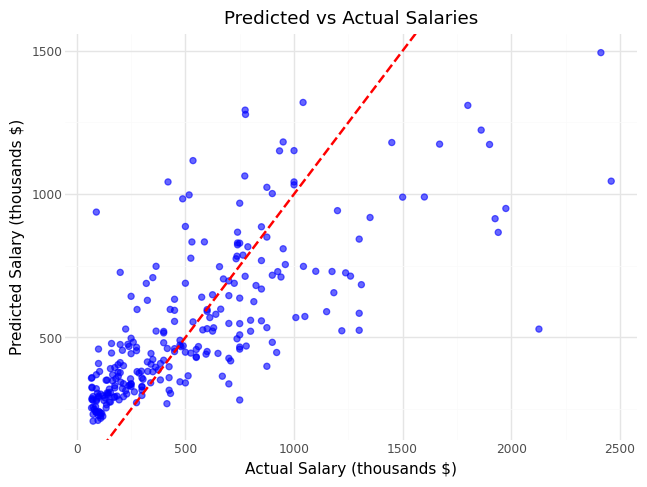

In [188]:
p1

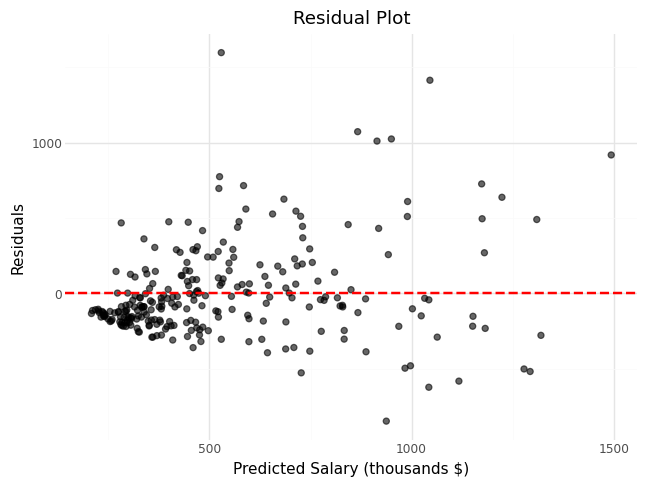

In [189]:
p2

The final Elastic Net model achieves the best predictive performance with a cross-validated MSE of 111,547, using
the top 5 career statistics and Division along with their pairwise interactions. The model identifies career runs
(CRuns), career walks (CWalks), and career at-bats (CAtBat) as the strongest predictors (top 3), with interaction terms ranking among the top 10 features, confirming that the relationship between performance metrics and salary is contextual rather than purely additive. This model's success demonstrates that combining strategic feature engineering (selecting top 5 variables + creating interactions) with hybrid regularization (elastic net which mixes ridge + lasso penalties) yields the best predictions compared to using all available features or simpler linear relationships.